# An RNN model for temperature data
Multi-site model

In [1]:
import math
import sys
import numpy as np
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


In [2]:
from matplotlib import pyplot as plt
from matplotlib import transforms as plttrans
import utils_prettystyle 

## Hyperparameters

In [3]:
N_FORWARD = 8       # train the network to predict N in advance (traditionnally 1)
RESAMPLE_BY = 5     # averaging period in days (training on daily data is too much)
RNN_CELLSIZE = 100  # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 100        # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)
ACTIVATION = tf.nn.tanh # Activation function for GRU cells (tf.nn.relu or tf.nn.tanh)

## Load temperatures

In [4]:
#32 weather stations
weather_stations = ['USC00010655.csv','USC00012813.csv','USC00016478.csv','USC00020949.csv','USC00021314.csv',
'USC00025635.csv','USC00026468.csv','USC00029359.csv','USC00030458.csv',
'USC00031948.csv','USC00032794.csv','USC00032930.csv','USC00033466.csv','USC00033821.csv','USC00033862.csv',
'USC00036920.csv','USC00036928.csv','USC00040343.csv','USC00041244.csv','USC00041428.csv',
'USC00042598.csv','USC00042713.csv','USC00042934.csv','USC00043551.csv','USC00043875.csv','USC00044957.csv',
'USC00045118.csv','USC00046074.csv','USC00046136.csv','USC00046730.csv','USC00047150.csv','USC00047916.csv']

# possible evaluation files: temperatures/USC00040343.csv"
with tf.gfile.Open("gs://ml1-demo-martin/good_temperature_data/USC00040343.csv", mode='rb') as f:
    eval_temperatures = np.genfromtxt(f, delimiter=",", skip_header=True,
                      usecols=[0,1,2,3], converters = {0: lambda s: np.datetime64(s)})

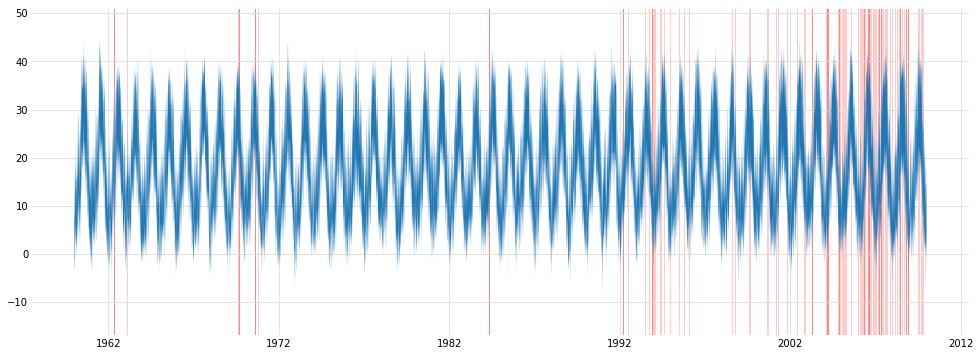

In [5]:
# You can adjust the visualisation range here
# Interpolated regions of the dataset are marked in red
visu_temperatures = eval_temperatures[:]

# when reading from CSV, numpy names its columns f0, f1, f2, ...
dates = visu_temperatures[:]['f0']
min_temps = visu_temperatures[:]['f1']
max_temps = visu_temperatures[:]['f2']
interpolated = visu_temperatures[:]['f3']

interpolated_sequence = False
#plt.plot(dates, max_temps)
for i, date in enumerate(dates):
    if interpolated[i]:
        if not interpolated_sequence:
            startdate = date
        interpolated_sequence = True
        stopdate=date
    else:
        if interpolated_sequence:
            # light shade of red just for visibility
            plt.axvspan(startdate+np.timedelta64(-5, 'D'), stopdate+np.timedelta64(6, 'D'), facecolor='#FFCCCC', alpha=1)
            # actual interpolated region
            plt.axvspan(startdate+np.timedelta64(-1, 'D'), stopdate+np.timedelta64(1, 'D'), facecolor='#FF8888', alpha=1)
        interpolated_sequence = False
plt.fill_between(dates, min_temps, max_temps).set_zorder(10)
plt.show()

## Resampling

In [6]:
# the dataset we will be working with
evaldata = np.stack([eval_temperatures[:]['f1'],  # min temperatures
                     eval_temperatures[:]['f2']], # max temteratures
                   axis=1)
evaldates = eval_temperatures[:]['f0'] # dates
rounded_data_len = evaldata.shape[0]//RESAMPLE_BY*RESAMPLE_BY
evaldata = np.reshape(evaldata[:rounded_data_len], [-1, RESAMPLE_BY, 2]) # 2: min temp, max temp
evaldata = np.mean(evaldata, axis=1)
evaldates = np.reshape(evaldates[:rounded_data_len], [-1, RESAMPLE_BY])
evaldates = evaldates[:,0] # one in five
print(evaldata.shape)

(3652, 2)


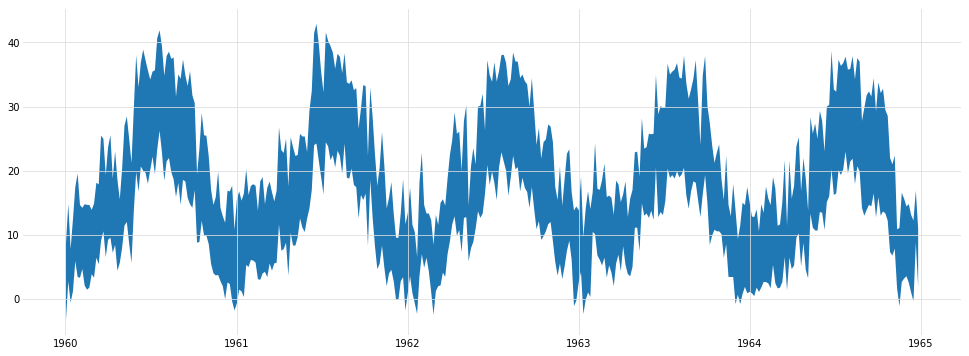

In [7]:
DISPLEN = 365*5//RESAMPLE_BY # 5 years
min_temps, max_temps = np.split(evaldata[:DISPLEN], 2, axis=1)
min_temps = np.squeeze(min_temps)
max_temps = np.squeeze(max_temps)
minmaxdates = evaldates[:DISPLEN]
plt.fill_between(minmaxdates, min_temps, max_temps) # display five years worth of data
plt.show()

## Build dataset

In [8]:
traindata = []
for station_i in range(BATCHSIZE):
    with tf.gfile.Open("gs://ml1-demo-martin/good_temperature_data/"+weather_stations[station_i], mode='rb') as f:
        temperatures = np.genfromtxt(f, delimiter=",",
                                     skip_header=True,
                                     usecols=[0,1,2,3],
                                     converters = {0: lambda s: np.datetime64(s)})
        temperatures = np.stack([temperatures[:]['f1'],  # min temperatures
                                 temperatures[:]['f2']], # max temperatures
                                axis=1)
        traindata.append(temperatures)
data = np.stack(traindata, axis=0)
print(data.shape)

(32, 18262, 2)


## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (32, 100, 2)
Label shape: (32, 100, 2)
First samples:


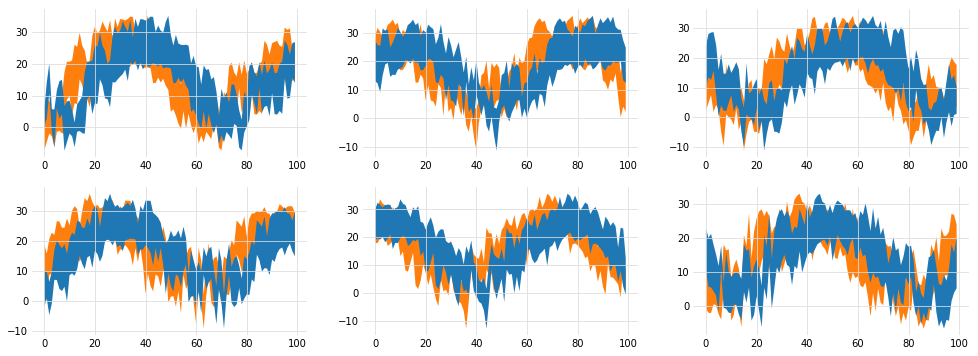

In [9]:
# The function rnn_sampling_sequencer puts one weather station per line in a batch
# and continues with data from the same station in corresponding lines in the next batch.
subplot = 231
for samples, labels, epoch in utils_batching.rnn_sampling_sequencer(data, RESAMPLE_BY, N_FORWARD, SEQLEN, nb_epochs=1):
    plt.subplot(subplot)
    tmin,tmax = np.split(samples[0], 2, axis=1)
    tmin,tmax = np.squeeze([tmin, tmax])
    plt.fill_between(np.arange(tmin.shape[0]), tmin, tmax)
    tmin,tmax = np.split(labels[0], 2, axis=1)
    tmin,tmax = np.squeeze([tmin, tmax])
    plt.fill_between(np.arange(tmin.shape[0]), tmin, tmax).set_zorder(-1)
    subplot += 1
    if subplot==237: break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("First samples:")
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [10]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    pairlen = tf.shape(X)[2] # should be 2 (tmin, tmax)
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE, activation=ACTIVATION) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 2], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin, dtype=tf.float32)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 2) # Yr [BATCHSIZE*SEQLEN, 2]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 2]) # Yr [BATCHSIZE, SEQLEN, 2]
    Yout = Yr[:,-N_FORWARD:,:] # Last N_FORWARD outputs Yout [BATCHSIZE, N_FORWARD, 2]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 2]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op, Yr

## Instantiate the model

In [11]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
labels = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op, Yr = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [12]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, N_FORWARD, 2])
    data_len = prime_data.shape[0]-N_FORWARD

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data[:-N_FORWARD])
        Yin = np.reshape(Yin, [1, data_len, 2]) # reshape as one sequence of pairs (tmin, tmax)
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        
        # initaiily, put real data on the inputs, not predictions
        Yout_ = np.expand_dims(prime_data[-N_FORWARD:], axis=0)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length//N_FORWARD):
        #Yout_ = np.reshape(Yout_, [1, N_FORWARD, 2]) # batch of a single sequence of a single vector (tmin, tmax)
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed) # Yout_ shape [1,2]
        results.append(Yout_[0]) # shape [N_FORWARD, 2]
        
    return np.concatenate(results, axis=0)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [13]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

epoch 0, batch 0, loss=360.8372


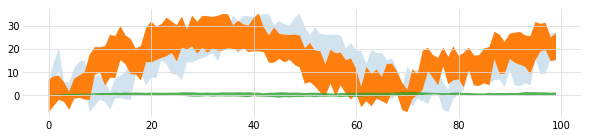

epoch 0, batch 30, loss=68.17205
epoch 1, batch 60, loss=66.78344
epoch 2, batch 90, loss=67.33992


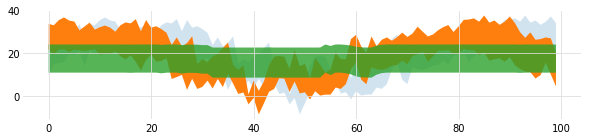

epoch 3, batch 120, loss=62.21462
epoch 4, batch 150, loss=59.627514
epoch 5, batch 180, loss=54.329254


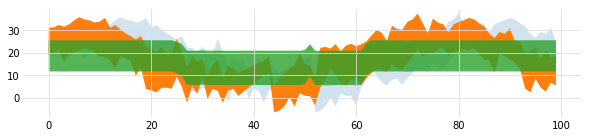

epoch 5, batch 210, loss=42.07377
epoch 6, batch 240, loss=26.637049
epoch 7, batch 270, loss=25.834702
epoch 8, batch 300, loss=21.65353


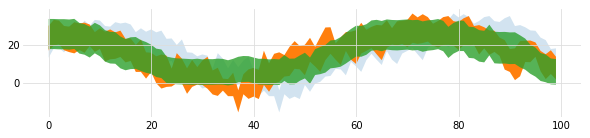

epoch 9, batch 330, loss=17.702852
epoch 10, batch 360, loss=24.105816
epoch 10, batch 390, loss=19.870499


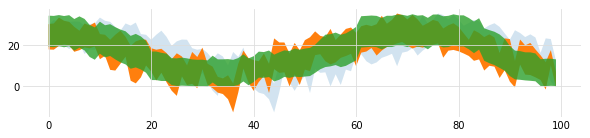

epoch 11, batch 420, loss=14.817852
epoch 12, batch 450, loss=25.120289
epoch 13, batch 480, loss=19.331072


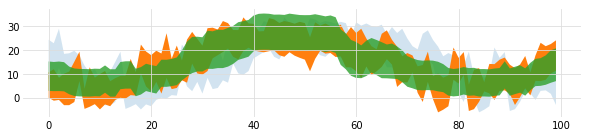

epoch 14, batch 510, loss=19.252464
epoch 15, batch 540, loss=21.93979
epoch 15, batch 570, loss=15.657112
epoch 16, batch 600, loss=13.654829


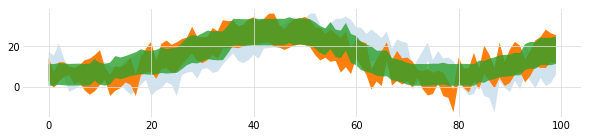

epoch 17, batch 630, loss=20.039715
epoch 18, batch 660, loss=15.786055
epoch 19, batch 690, loss=15.267614


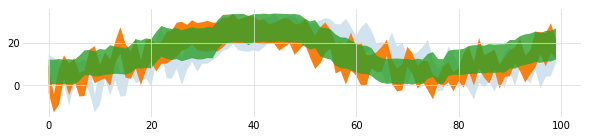

epoch 20, batch 720, loss=23.48384
epoch 20, batch 750, loss=14.544228
epoch 21, batch 780, loss=13.216687


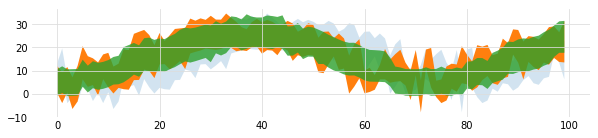

epoch 22, batch 810, loss=20.277527
epoch 23, batch 840, loss=17.27073
epoch 24, batch 870, loss=13.957048
epoch 25, batch 900, loss=19.430891


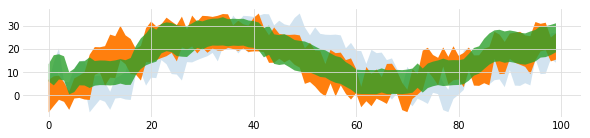

epoch 25, batch 930, loss=14.9500265
epoch 26, batch 960, loss=13.488147
epoch 27, batch 990, loss=17.5027


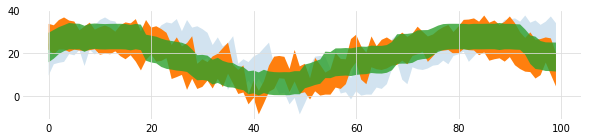

epoch 28, batch 1020, loss=13.9690275
epoch 29, batch 1050, loss=12.25949


In [14]:
NB_EPOCHS = 30

H_ = Hzero
losses = []
indices = []
last_epoch = 0
for i, (next_samples, next_labels, epoch) in enumerate(utils_batching.rnn_sampling_sequencer(data, RESAMPLE_BY, N_FORWARD, SEQLEN, nb_epochs=NB_EPOCHS)):
    
    # reinintialize state between epochs
    if epoch != last_epoch:
        H_ = Hzero

    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _, Yr_ = sess.run([Yout, H, loss, train_op, Yr], feed_dict=feed)
    last_epoch = epoch
    
    # print progress
    if i%30 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
        sys.stdout.flush()
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
# This visualisation can be helpful to see how the model "locks" on the shape of the curve
    if i%100 == 0:
        plt.figure(figsize=(10,2))
        disp_min, disp_max = np.squeeze(np.split(next_samples[0,:], 2, axis=1))
        plt.fill_between(np.arange(disp_min.shape[0]), disp_min, disp_max).set_alpha(0.2)
        disp_min, disp_max = np.squeeze(np.split(next_labels[0,:], 2, axis=1))
        plt.fill_between(np.arange(disp_min.shape[0]), disp_min, disp_max)
        disp_min, disp_max = np.squeeze(np.split(Yr_[0,:], 2, axis=1))
        plt.fill_between(np.arange(disp_min.shape[0]), disp_min, disp_max).set_alpha(0.8)
        plt.show()

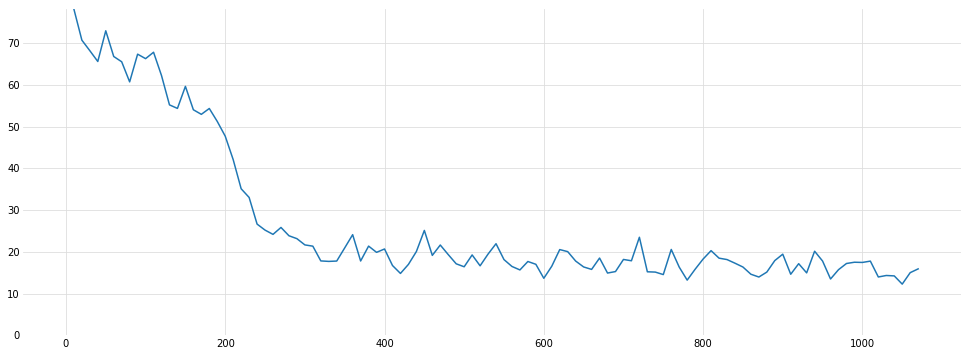

In [15]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

In [16]:
print(evaldata.shape)

(3652, 2)


In [25]:
PRIMELEN=512
RUNLEN=512
OFFSET=500
RMSELEN=128
prime_data = evaldata[OFFSET:OFFSET+PRIMELEN]
results = prediction_run(prime_data, RUNLEN)
print(results.shape)

(512, 2)


(1024,)


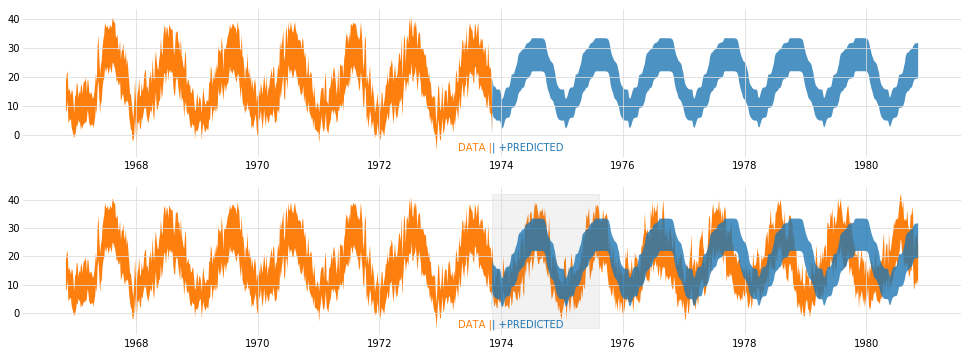

In [26]:
disp_data = evaldata[OFFSET:OFFSET+PRIMELEN+RUNLEN]
disp_dates = evaldates[OFFSET:OFFSET+PRIMELEN+RUNLEN]
print(disp_dates.shape)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sp = plt.subplot(211)
trans = plttrans.blended_transform_factory(sp.transData, sp.transAxes)
plt.text(disp_dates[PRIMELEN],0.05,"DATA |", color=colors[1], horizontalalignment="right", transform=trans)
plt.text(disp_dates[PRIMELEN],0.05,"| +PREDICTED", color=colors[0], horizontalalignment="left", transform=trans)
displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN,2]), results)))
displayresults = np.ma.masked_where(displayresults == 0, displayresults)
disp_min, disp_max = np.squeeze(np.split(displayresults, 2, axis=1))
plt.fill_between(disp_dates, disp_min, disp_max).set_alpha(0.8)
displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN,2]))))
displaydata = np.ma.masked_where(displaydata == 0, displaydata)
disp_min, disp_max = np.squeeze(np.split(displaydata, 2, axis=1))
plt.fill_between(disp_dates, disp_min, disp_max)
sp = plt.subplot(212)
disp_min, disp_max = np.squeeze(np.split(displayresults, 2, axis=1))
p = plt.fill_between(disp_dates, disp_min, disp_max)
p.set_alpha(0.8)
p.set_zorder(10)
trans = plttrans.blended_transform_factory(sp.transData, sp.transAxes)
plt.text(disp_dates[PRIMELEN],0.05,"DATA |", color=colors[1], horizontalalignment="right", transform=trans)
plt.text(disp_dates[PRIMELEN],0.05,"| +PREDICTED", color=colors[0], horizontalalignment="left", transform=trans)
disp_min, disp_max = np.squeeze(np.split(disp_data, 2, axis=1))
plt.fill_between(disp_dates, disp_min, disp_max)
plt.axvspan(disp_dates[PRIMELEN], disp_dates[PRIMELEN+RMSELEN], color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
plt.show()

In [27]:
rmse = math.sqrt(np.mean((evaldata[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))
sys.stdout.flush()

RMSE on 128 predictions (shaded area): 4.347392423413679


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.